In [1]:
import pandas as pd
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
%matplotlib inline

# Data gathering

In [2]:
fill = pd.read_excel('Data.xlsx')
stats = pd.ExcelFile('Stats.xlsx')

In [3]:
def get_init(fill, stats, x):
    name = fill.iloc[x].Player
    year = fill.iloc[x].Summer[:4]
    sheet = stats.parse(name)
    sheet['MPG'] = (sheet['MP'] / sheet['G']).apply(lambda x : round(x,2))
    sheet = sheet[['Season', 'Age', 'G', 'MP', 'MPG', 'PER', 'TS%', 'TOV%', 'USG%', 'WS/48', 'OBPM',
       'DBPM', 'BPM', 'VORP']]
    return name, year, sheet

In [4]:
def get_seasons(data, num):
    SA = data.iloc[num].tolist() + [0]
    SB = data.iloc[num-1].tolist() + [0]
    TwoSB = data.iloc[num-2].tolist() + [0]
    return SA + SB + TwoSB

In [5]:
def get_avg(data, num):
    # no diffs
    temp = data.iloc[0:num]
    avg = temp[temp.columns.tolist()[2:]].mean().tolist() + [0]
    temp2 = temp[temp['Season'] != '2011-12'][temp.columns.tolist()[2:4]].copy()
    avg[:2] = temp2.mean().tolist()
    # diffs
    diff = temp[temp.columns.tolist()[2:]].diff()
    diff.dropna(inplace=True)
    del_avg = diff.mean().tolist() + [0]
    diff2 = temp2.diff()
    diff2.dropna(inplace=True)
    del_avg[:2] = diff2.mean().tolist()
    return avg + del_avg

In [6]:
df = pd.DataFrame()
for x in fill.index:
    name, year, sheet = get_init(fill, stats, x)
    num = sheet[sheet['Season'].apply(lambda x : x[:4] == year)].index[0] # still accounts for when they play for multiple teams
                                                                          # in one year
    list1 = get_seasons(sheet, num)
    list2 = get_avg(sheet, num)
    df = df.append(pd.DataFrame({name : list1 + list2}).T)
df.columns = fill.columns[14:]
df.to_excel('fill_in.xlsx')

After this, I copy-pasted "fill_in.xlsx" into relevant parts of "data_final.xlsx"

# Core Analysis: t-tests

In [7]:
data = pd.read_excel('data_final.xlsx')
data.columns

Index(['Player', 'Position', 'Height - feet', 'Height - in', 'Weight',
       'Summer', 'Age_Su', 'GP_Su', 'GS_Su', 'MPG_Su', 'RPG_Su', 'APG_Su',
       'PPG_Su', 'Injured?_Su', 'Season_SA', 'Age_SA', 'G_SA', 'MP_SA',
       'MPG_SA', 'PER_SA', 'TS%_SA', 'TOV%_SA', 'USG%_SA', 'WS/48_SA',
       'OBPM_SA', 'DBPM_SA', 'BPM_SA', 'VORP_SA', 'Injured?_SA', 'Season_SB',
       'Age_SB', 'G_SB', 'MP_SB', 'MPG_SB', 'PER_SB', 'TS%_SB', 'TOV%_SB',
       'USG%_SB', 'WS/48_SB', 'OBPM_SB', 'DBPM_SB', 'BPM_SB', 'VORP_SB',
       'Injured?_SB', 'Season_2SB', 'Age_2SB', 'G_2SB', 'MP_2SB', 'MPG_2SB',
       'PER_2SB', 'TS%_2SB', 'TOV%_2SB', 'USG%_2SB', 'WS/48_2SB', 'OBPM_2SB',
       'DBPM_2SB', 'BPM_2SB', 'VORP_2SB', 'Injured?_2SB', 'G_AVG', 'MP_AVG',
       'MPG_AVG', 'PER_AVG', 'TS%_AVG', 'TOV%_AVG', 'USG%_AVG', 'WS/48_AVG',
       'OBPM_AVG', 'DBPM_AVG', 'BPM_AVG', 'VORP_AVG', 'Injured?', 'G_DEL_AVG',
       'MP_DEL_AVG', 'MPG_DEL_AVG', 'PER_DEL_AVG', 'TS%_DEL_AVG',
       'TOV%_DEL_AVG', 'USG%_DE

In [8]:
data.describe()

,Height - feet,Height - in,Weight,Age_Su,GP_Su,GS_Su,MPG_Su,RPG_Su,APG_Su,PPG_Su,...,PER_DEL_AVG,TS%_DEL_AVG,TOV%_DEL_AVG,USG%_DEL_AVG,WS/48_DEL_AVG,OBPM_DEL_AVG,DBPM_DEL_AVG,BPM_DEL_AVG,VORP_DEL_AVG,Injured?.1
count,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,...,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,48.000000
mean,6.041667,6.437500,224.645833,25.250000,8.291667,3.541667,16.891667,3.439583,1.850000,8.727083,...,1.328305,0.008597,-0.411652,1.065418,0.019483,0.781987,0.063066,0.842061,0.620351,0.729167
std,0.201941,3.221644,23.922294,3.290864,0.874176,4.109969,6.128616,1.938385,1.396957,4.688271,...,1.486329,0.016500,0.787453,1.206786,0.023982,0.837079,0.471021,0.982883,0.605146,0.449093
min,6.000000,0.000000,175.000000,19.000000,4.000000,0.000000,5.800000,0.600000,0.000000,1.900000,...,-1.575000,-0.022500,-2.000000,-1.050000,-0.034000,-1.000000,-2.100000,-1.125000,-0.325000,0.000000
25%,6.000000,3.000000,208.500000,23.000000,8.000000,0.000000,11.675000,1.975000,0.800000,4.950000,...,0.412500,0.001500,-1.000000,0.243750,0.005714,0.300000,-0.050000,0.266667,0.193750,0.000000
50%,6.000000,7.000000,222.500000,25.000000,8.000000,0.000000,17.400000,2.750000,1.400000,8.400000,...,1.000000,0.006364,-0.453333,0.800000,0.016667,0.614286,0.071429,0.733333,0.557143,1.000000
75%,6.000000,9.000000,240.000000,27.000000,9.000000,8.000000,22.000000,4.925000,2.675000,11.725000,...,2.366667,0.014625,0.025000,1.850000,0.028750,1.325000,0.300000,1.300000,0.950000,1.000000
max,7.000000,11.000000,280.000000,33.000000,9.000000,9.000000,28.800000,7.700000,5.600000,22.800000,...,5.200000,0.061000,1.933333,4.600000,0.099000,2.750000,1.100000,3.250000,2.700000,1.000000


Season_after vs. season_before

In [9]:
list1 = []
for stat in ['PER', 'TS%', 'TOV%', 'USG%', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP']:
    a = data[stat + '_SA']
    b = data[stat + '_SB']
    list1.append(ttest_ind(a, b)[1])
#     print (stat + ': ' + str(ttest_ind(a, b)[1]))
list1 = pd.DataFrame({'Comp. #1: Season after vs. Season before' : list1})

(Season after - season before) vs. (Season before - Two seasons before)

In [10]:
data2 = data.copy()
data2.dropna(inplace=True)
data2.reset_index(drop=True, inplace=True)

In [11]:
list2 = []
for stat in ['PER', 'TS%', 'TOV%', 'USG%', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP']:
    a = data2[stat + '_SA'] - data2[stat + '_SB']
    b = data2[stat + '_SB'] - data2[stat + '_2SB']
    list2.append(ttest_ind(a, b)[1])
#     print (stat + ': ' + str(ttest_ind(a, b)[1]))
list2 = pd.DataFrame({'Comp #2: (Season after - Season before) vs (Season before - 2 Seasons before)' : list2})

(Season after - season before) vs. (Average delta before)

In [12]:
data2 = data.copy()
data2.dropna(inplace=True)
data2.reset_index(drop=True, inplace=True)

In [13]:
list3 = []
for stat in ['PER', 'TS%', 'TOV%', 'USG%', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP']:
    a = data2[stat + '_SA'] - data2[stat + '_SB']
    b = data2[stat + '_DEL_AVG']
    list3.append(ttest_ind(a, b)[1])
#     print (stat + ': ' + str(ttest_ind(a, b)[1]))
list3 = pd.DataFrame({'Comp #3: (Season after - Season before) vs (Average of Changes of All Seasons Before)' : list3})

Overall results

In [14]:
results = pd.concat([list1, list2, list3], axis=1)
results.index = ['PER', 'TS%', 'TOV%', 'USG%', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP']
results

,Comp. #1: Season after vs. Season before,Comp #2: (Season after - Season before) vs (Season before - 2 Seasons before),Comp #3: (Season after - Season before) vs (Average of Changes of All Seasons Before)
PER,0.220654,0.810376,0.803950
TS%,0.617611,0.849619,0.833774
TOV%,0.308763,0.075446,0.486360
USG%,0.600118,0.694450,0.590157
WS/48,0.282111,0.842358,0.603179
OBPM,0.316614,0.822422,0.476926
DBPM,0.933539,0.545690,0.735585
BPM,0.402894,0.670781,0.444351
VORP,0.283801,0.834848,0.657610


# Analyzing the TOV% with p-level = 0.075

Initial glance at the data in question

In [15]:
(data2['TOV%_SA'] - data2['TOV%_SB']).describe()

count    45.000000
mean     -0.662222
std       2.271892
min     -11.900000
25%      -1.500000
50%      -0.700000
75%       0.300000
max       3.300000
dtype: float64

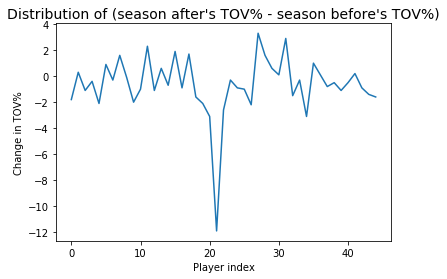

In [16]:
plt.plot(data2['TOV%_SA'] - data2['TOV%_SB'])
plt.xlabel('Player index')
plt.ylabel('Change in TOV%')
plt.title("Distribution of (season after's TOV% - season before's TOV%)", 
          fontsize=14)

In [17]:
(data2['TOV%_SB'] - data2['TOV%_2SB']).describe()

count    45.000000
mean      0.242222
std       2.492488
min      -4.600000
25%      -1.400000
50%       0.000000
75%       0.900000
max       9.000000
dtype: float64

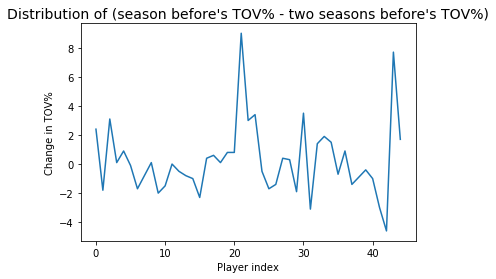

In [18]:
plt.plot(data2['TOV%_SB'] - data2['TOV%_2SB'])
plt.xlabel('Player index')
plt.ylabel('Change in TOV%')
plt.title("Distribution of (season before's TOV% - two seasons before's TOV%)", 
          fontsize=14)

In [19]:
(data2['TOV%_SA'] - data2['TOV%_SB']).sort_values().head()

21   -11.9
20    -3.1
34    -3.1
22    -2.6
26    -2.2
dtype: float64

In [20]:
(data2['TOV%_SB'] - data2['TOV%_2SB']).sort_values(ascending=False).head()

21    9.0
43    7.7
30    3.5
23    3.4
2     3.1
dtype: float64

In [21]:
# Tyson Chandler is the main outlier for both (season after - season before) and (season before - two seasons before)

pd.DataFrame(data2.iloc[21][['Player', 'Summer', 'TOV%_SA', 'TOV%_SB', 'TOV%_2SB']]).T

,Player,Summer,TOV%_SA,TOV%_SB,TOV%_2SB
21,Tyson Chandler,2010 FIBA,14.1,26,17


In [22]:
# Draymond Green is the other outlier

pd.DataFrame(data2.iloc[43][['Player', 'Summer', 'TOV%_SA', 'TOV%_SB', 'TOV%_2SB']]).T

,Player,Summer,TOV%_SA,TOV%_SB,TOV%_2SB
43,Draymond Green,2016 Olympics,19.8,21.2,13.5


Seeing effect of removing the Tyson Chandler and Draymond Green outliers

In [23]:
data3 = data2[~((data2.Player == 'Tyson Chandler') & (data2.Summer == '2010 FIBA')) & (data2.Player != 'Draymond Green')]

In [24]:
(data3['TOV%_SA'] - data3['TOV%_SB']).describe()

count    43.000000
mean     -0.383721
std       1.519231
min      -3.100000
25%      -1.300000
50%      -0.500000
75%       0.450000
max       3.300000
dtype: float64

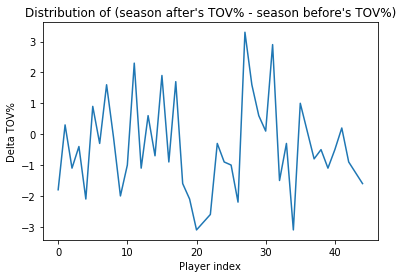

In [25]:
plt.plot(data3['TOV%_SA'] - data3['TOV%_SB'])
plt.xlabel('Player index')
plt.ylabel('Delta TOV%')
plt.title("Distribution of (season after's TOV% - season before's TOV%)")

In [26]:
(data3['TOV%_SB'] - data3['TOV%_2SB']).describe()

count    43.000000
mean     -0.134884
std       1.792296
min      -4.600000
25%      -1.400000
50%      -0.100000
75%       0.850000
max       3.500000
dtype: float64

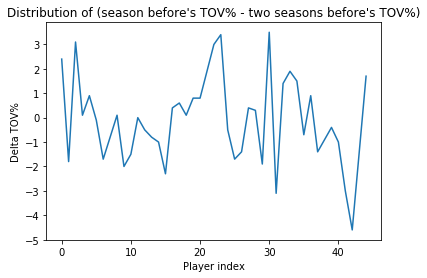

In [27]:
plt.plot(data3['TOV%_SB'] - data3['TOV%_2SB'])
plt.xlabel('Player index')
plt.ylabel('Delta TOV%')
plt.title("Distribution of (season before's TOV% - two seasons before's TOV%)")

In [28]:
ttest_ind((data3['TOV%_SA'] - data3['TOV%_SB']), (data3['TOV%_SB'] - data3['TOV%_2SB']))[1]

0.48929262784404992

In [29]:
data3 = data2[~((data2.Player == 'Tyson Chandler') & (data2.Summer == '2010 FIBA'))] # just removing Tyson
ttest_ind((data3['TOV%_SA'] - data3['TOV%_SB']), (data3['TOV%_SB'] - data3['TOV%_2SB']))[1]

0.25588473087253455

In [30]:
# So, the apparent significance is due to random outliers

# Comparing # of injuries over time

In [31]:
injuries = pd.DataFrame(data.sum()[['Injured?', 'Injured?_2SB', 'Injured?_SB','Injured?_Su', 'Injured?_SA']])
injuries.columns = ['Total # of Players']
injuries.index = ['Injured in any season before summer play?', 
                  'Injured two seasons before summer play?',
                  'Injured the season before summer play?',
                  'Injured during summer play?',
                  'Injured the season after summer play?'
                 ]
injuries

,Total # of Players
Injured in any season before summer play?,35
Injured two seasons before summer play?,21
Injured the season before summer play?,22
Injured during summer play?,1
Injured the season after summer play?,31


In [32]:
ttest_ind(data['Injured?_SA'], data['Injured?_SB'])

Ttest_indResult(statistic=1.8611980643550203, pvalue=0.065841505882769005)

In [33]:
ttest_ind(data['Injured?_SA'] - data['Injured?_SB'], data['Injured?_SB'] - data['Injured?_2SB'])

# This is interesting - maybe different players got injured

Ttest_indResult(statistic=1.3140589260300388, pvalue=0.19202412795941154)

In [34]:
players_2SB = data[data['Injured?_2SB'] == 1].Player.tolist()
players_SB = data[data['Injured?_SB'] == 1].Player.tolist()
players_SA = data[data['Injured?_SA'] == 1].Player.tolist()

In [35]:
a = (set(players_SA) - set(players_SB))
b = (set(players_SB) - set(players_SA))
c = (set(players_SB) - set(players_2SB))
d = (set(players_2SB) - set(players_SB))

print ('Players injured after but not before summer play:', len(a))
print(a)
print ()
print ('Players injured before but not after summer play:',len(b))
print(b)
print ()
print ('Players injured one season before but not two seasons before summer play:',len(c))
print (c)
print ()
print ('Players injured two seasons before but not one season before summer play:',len(d))
print (d)

Players injured after but not before summer play: 9
{'Russell Westbrook', 'Paul George', 'Chauncey Billups', 'Andre Iguodala', 'Chris Paul', 'Stephen Curry', 'Kyle Lowry', 'Draymond Green', 'LeBron James'}

Players injured before but not after summer play: 4
{'James Harden', 'Andre Drummond', 'Danny Granger', 'Harrison Barnes'}

Players injured one season before but not two seasons before summer play: 4
{'Kobe Bryant', 'James Harden', 'Andre Drummond', 'Harrison Barnes'}

Players injured two seasons before but not one season before summer play: 4
{'Deron Williams', 'Andre Iguodala', 'Paul George', 'Stephen Curry'}
